# Lab Vision Systems: Session 4

# Today:

### 1: Solution Assignment 3
### 2: Recurrent Neural Networks (RNNs)
### 3: Training your RNN in PyTorch

In [3]:
import torch

In [4]:
torch.cuda.is_available()

True

# 0. Some Comments

### - Some Errors in Assignment

Some assignments had some low classification accuracies.
After looking a bit into them, some reasons where:
 - Not using pretrained models
 - Training for too few epochs with a very low learning rate

### CutMix and MixUp


### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; **CutMix** &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; **MixUp**

<img src="./imgs/cutmix.png" width=49%> <img src="./imgs/mixup.png" width=49%>

---

# 1. Solution Assignment 3

Presented by: Jonas Marcic

#### Some Interesting Examples

---

<img src="./imgs/fun_1.png" width=20%><img src="./imgs/fun_2.png" width=20%><img src="./imgs/fun_3.png" width=20%>

<img src="./imgs/fun_5.png" width=40%> <img src="./imgs/fun_4.png" width=29%>

# 2. Recurrent Neural Networks

# 3. Motion Classification with RNNs

  ####  1. Embed each frame into a single vector embedding
  ####  2. Sequentially feed embeddings to RNN 
  ####  3. Classify RNN output with a fully-connected layer to estimate the motion direction


<img src="./imgs/gif_00.gif" width=15%> <img src="./imgs/gif_01.gif" width=15%> <img src="./imgs/gif_02.gif" width=15%> <img src="./imgs/gif_03.gif" width=15%> <img src="./imgs/gif_04.gif" width=15%>

<img src="./imgs/pipeline.png">

In [5]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms

## Creating Dataset

In [6]:
class MotionDataset:
    """
    Dataset for motion classification
    """
    
    LABELS = {
        0: "down",
        1: "up",
        2: "right",
        3: "left"
    }
    
    def __init__(self, train, transform, img_size=(64, 64), num_frames=5, resize=1, move=2):
        """ """ 
        self.img_size = img_size
        self.num_frames = num_frames
        self.resize = resize
        self.move = move
        self.mnist_db = datasets.MNIST(root='./data', train=train, transform=transform, download=True)
        return

    def __len__(self):
        """ """
        return len(self.mnist_db)
    
    def __getitem__(self, i):
        """ Creating a random sequence of a moving digit"""
        # sampling digit
        digit = self.mnist_db[i][0]
        digit = F.interpolate(digit.unsqueeze(0), scale_factor=1/self.resize)[0]
        digitH, digitW = digit.shape[-2], digit.shape[-1]
        
        # creating canvas
        canvasH, canvasW = self.img_size
        canvas = torch.zeros(self.num_frames, 1, canvasH, canvasW)
        start_pos_x = np.random.randint(8, canvasH - 8 - digitH)
        start_pos_y = np.random.randint(8, canvasH - 8 - digitH)
        start_pos = torch.tensor([start_pos_y, start_pos_x])
        
        # moving parameters
        n = np.random.rand()
        
        if n < 0.25:
            move = torch.tensor([self.move, 0])
            label = 0
        elif n < 0.5:
            move = torch.tensor([-self.move, 0])
            label = 1
        elif n < 0.75:
            move = torch.tensor([0, self.move])
            label = 2
        else:
            move = torch.tensor([0, -self.move])
            label = 3
        
        # updating positions and creating video
        positions = []
        for i in range(self.num_frames):
            if i == 0:
                cur_pos = start_pos
            else:
                cur_pos = positions[-1] + move
            positions.append(cur_pos)
            canvas[i, :, cur_pos[0]:cur_pos[0]+digitH, cur_pos[1]:cur_pos[1] + digitW] = digit
        
        return canvas, label
    

In [7]:
def visualize_sequence(sequence,  suptitle="", add_title=True, add_axis=False, n_cols=5, size=1.5,  vmax=1, vmin=0, **kwargs):
    """ Visualizing a grid with several images/frames """
    n_frames = sequence.shape[0]
    n_rows = int(np.ceil(n_frames / n_cols))

    fig, ax = plt.subplots(n_rows, n_cols)
    fig.set_size_inches(size * n_cols, size + 0.5)
    fig.suptitle(suptitle)
 
    ims = []
    fs = []
    for i in range(n_frames):
        a = ax[i]
        f = sequence[i, 0].cpu().detach()
        a.imshow(f, vmin=vmin, vmax=vmax, **kwargs)
        if add_title:
            a.set_title(f"Frame {i}", fontsize=12)
        if not add_axis:
            a.set_yticks([])
            a.set_xticks([])
    plt.tight_layout()
    return

In [8]:
train_dataset = MotionDataset(
        train=True,
        transform=transforms.ToTensor(),
        img_size=(32, 32),
        num_frames=4,
        resize=2
    )

test_dataset = MotionDataset(
        train=False,
        transform=transforms.ToTensor(),
        img_size=(32, 32),
        num_frames=4,
        resize=2
    )

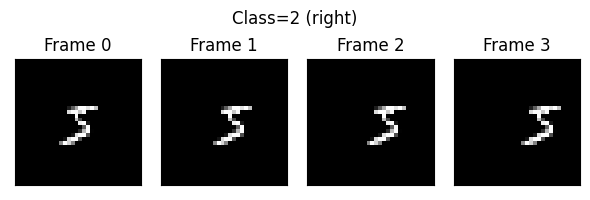

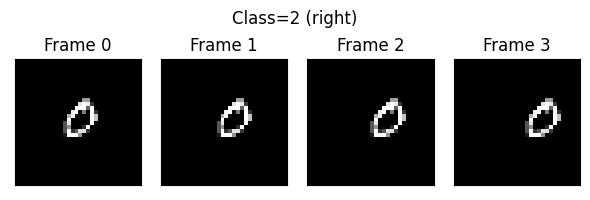

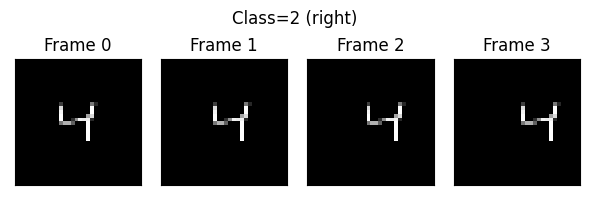

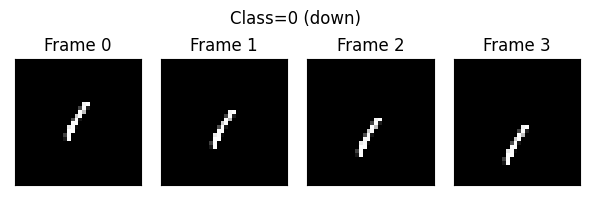

In [10]:
for i in range(4):
    frames, label = train_dataset[i]
    visualize_sequence(frames, n_cols=4, cmap="gray", suptitle=f"Class={label} ({train_dataset.LABELS[label]})")

In [11]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)

## Model

#### **Important:** PyTorch includes nn.LSTM() and nn.LSTMCell(). These two are inherently different!

See https://pytorch.org/docs/stable/nn.html#recurrent-layers

In [12]:
class SequentialClassifier(nn.Module):
    """ 
    Sequential classifier. Embedded images are fed to a RNN
    
    Args:
    -----
    emb_dim: integer 
        dimensionality of the vectors fed to the LSTM
    hidden_dim: integer
        dimensionality of the states in the cell
    num_layers: integer
        number of stacked LSTMS
    mode: string
        intialization of the states
    """
    
    def __init__(self, emb_dim, hidden_dim, num_layers=1, mode="zeros"):
        """ Module initializer """
        assert mode in ["zeros", "random"]
        super().__init__()
        self.hidden_dim =  hidden_dim
        self.num_layers = num_layers
        self.mode = mode
        
        # for embedding rows into vector representations
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(128, emb_dim, 3, 1, 1),
                nn.AdaptiveAvgPool2d((1, 1))
            )
        
        # LSTM model
        self.lstm = nn.LSTM(
                input_size=emb_dim,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                batch_first=True
            )
        
        # FC-classifier
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=4)
        
        return
    
    
    def forward(self, x):
        """ Forward pass through model """
        
        b_size, num_frames, n_channels, n_rows, n_cols = x.shape
        h, c = self.init_state(b_size=b_size, device=x.device) 
        
        # encoding all images in parallel rows
        x = x.view(b_size * num_frames, n_channels, n_rows, n_cols)
        embeddings = self.encoder(x)
        embeddings = embeddings.reshape(b_size, num_frames, -1)

        # feeding LSTM. Does everything for you
        lstm_out, (h_out, c_out) = self.lstm(embeddings, (h, c)) 
        
        # classifying
        y = self.classifier(lstm_out[:, -1, :])  # feeding only output at last layer
        
        return y
    
        
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim)
            c = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
            c = torch.randn(self.num_layers, b_size, self.hidden_dim)
        h = h.to(device)
        c = c.to(device)
        return h, c

In [13]:
class SequentialClassifierWithCells(nn.Module):
    """ 
    Sequential classifier. Embedded images are fed to a RNN
    Same as above, but using LSTMCells instead of the LSTM object
    
    Args:
    -----
    emb_dim: integer 
        dimensionality of the vectors fed to the LSTM
    hidden_dim: integer
        dimensionality of the states in the cell
    num_layers: integer
        number of stacked LSTMS
    mode: string
        intialization of the states
    """
    
    def __init__(self, emb_dim, hidden_dim, num_layers=1, mode="zeros"):
        """ Module initializer """
        assert mode in ["zeros", "random"]
        super().__init__()
        self.hidden_dim =  hidden_dim
        self.num_layers = num_layers
        self.mode = mode

        # for embedding rows into vector representations
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(128, emb_dim, 3, 1, 1),
                nn.AdaptiveAvgPool2d((1, 1))
            )
        
        # LSTM model       
        lstms = []
        for i in range(num_layers):
            in_size = emb_dim if i == 0 else hidden_dim
            lstms.append( nn.LSTMCell(input_size=in_size, hidden_size=hidden_dim) )
        self.lstm = nn.ModuleList(lstms)
        
        # FC-classifier
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=4)
        
        return
    
    
    def forward(self, x):
        """ Forward pass through model """
        
        b_size, num_frames, n_channels, n_rows, n_cols = x.shape
        h, c = self.init_state(b_size=b_size, device=x.device) 
        
        # embedding rows
        x = x.view(b_size * num_frames, n_channels, n_rows, n_cols)
        embeddings = self.encoder(x)
        embeddings = embeddings.reshape(b_size, num_frames, -1)
        
        # iterating over sequence length
        lstm_out = []
        for i in range(embeddings.shape[1]):
            lstm_input = embeddings[:, i, :]
            # iterating over LSTM Cells
            for j, lstm_cell in enumerate(self.lstm):
                h[j], c[j] = lstm_cell(lstm_input, (h[j], c[j]))
                lstm_input = h[j]
            lstm_out.append(lstm_input)
        lstm_out = torch.stack(lstm_out, dim=1)
            
        # classifying
        y = self.classifier(lstm_out[:, -1, :])  # feeding only output at last layer
        
        return y
    
        
    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        elif(self.mode == "random"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        return h, c

## Training Code 

In [14]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"    Train loss: {round(mean_loss, 5)}")
        print(f"    Valid loss: {round(loss, 5)}")
        print(f"    Accuracy: {accuracy}%")
        print("\n")
        save_model(
                model=model,
                optimizer=optimizer,
                epoch=epoch,
                stats={
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "loss_iters": loss_iters,
                    "valid_acc": valid_acc,
                }
            )
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params


def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

## Training

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
# model = SequentialClassifier(emb_dim=128, hidden_dim=128, num_layers=2, mode="zeros")
model = SequentialClassifierWithCells(emb_dim=128, hidden_dim=128, num_layers=2, mode="zeros")
count_model_params(model)

486788

In [38]:
print(model.encoder)
count_model_params(model.encoder)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): AdaptiveAvgPool2d(output_size=(1, 1))
)


222080

In [39]:
3*3*1*64 + 64 + 64 * 128 * 3 * 3 + 128 + 128 * 128 * 3 * 3 + 128

222080

In [40]:
print(model.lstm)
count_model_params(model.lstm)

ModuleList(
  (0): LSTMCell(128, 128)
  (1): LSTMCell(128, 128)
)


264192

In [41]:
4 * (2 * (128 * 128 + 128)) * 2

264192

In [42]:
print(model.classifier)
count_model_params(model.classifier)

Linear(in_features=128, out_features=4, bias=True)


516

In [43]:
128 * 4 + 4

516

In [44]:
model = model.to(device)

In [45]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [46]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=test_loader, num_epochs=10
    )

Epoch 1 Iter 235: loss 1.19909. : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:23<00:00, 10.21it/s]


Epoch 1/10
    Train loss: 1.38019
    Valid loss: 1.38779
    Accuracy: 25.77%




Epoch 2 Iter 85: loss 0.44190. :  36%|████████████████████████████████████████████████████████████                                                                                                          | 85/235 [00:08<00:15,  9.79it/s]


KeyboardInterrupt: 

In [ ]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs[1:], valid_acc[1:], c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()

## Does it work?

In [52]:
# model = SequentialClassifierWithCells(emb_dim=128, hidden_dim=128, num_layers=2, mode="zeros")
model = SequentialClassifier(emb_dim=128, hidden_dim=128, num_layers=2, mode="zeros")
model, optimizer, epoch, stats = load_model(
        model=model,
        optimizer=optimizer,
        # savepath=os.path.join(os.getcwd(), "_back_models", "Cells", "models", "checkpoint_epoch_9.pth")
        savepath=os.path.join(os.getcwd(), "_back_models", "LSTM", "models", "checkpoint_epoch_9.pth")
    )
model = model.to(device)

In [53]:
stats.keys()

dict_keys(['train_loss', 'val_loss', 'loss_iters', 'valid_acc'])

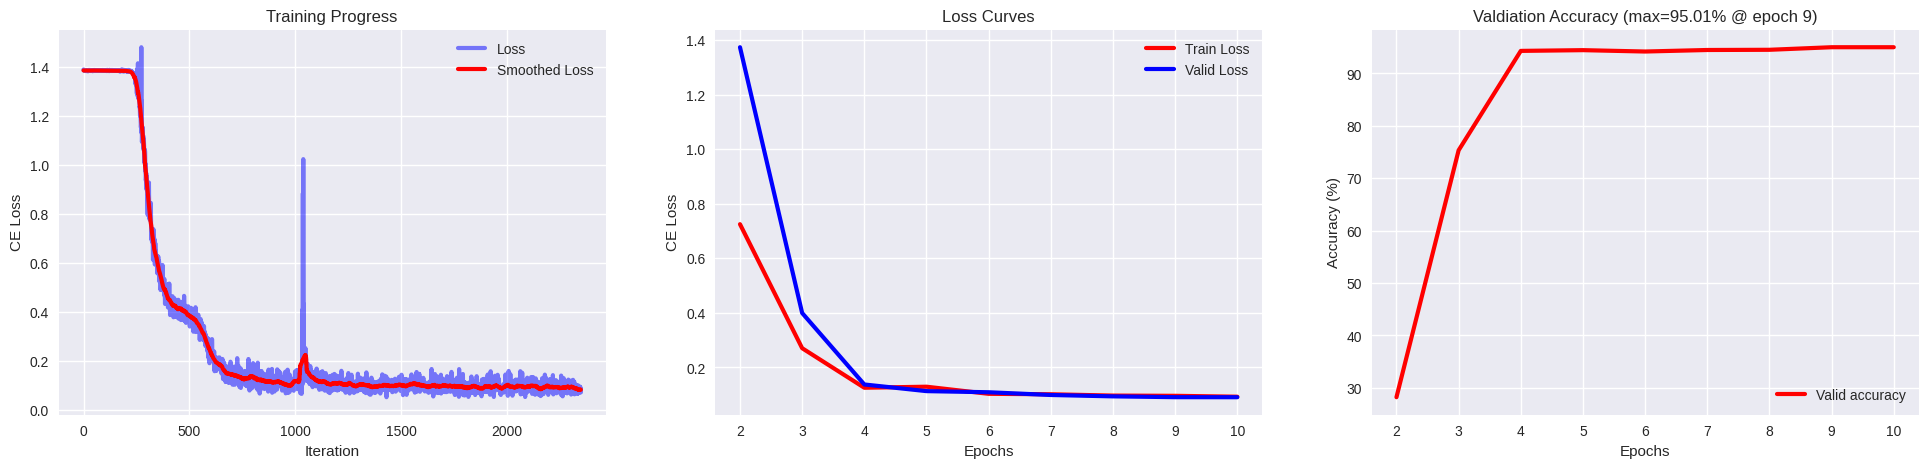

In [54]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,3)
fig.set_size_inches(24,5)

loss_iters = stats.get("loss_iters")
train_loss = stats.get("train_loss")
val_loss = stats.get("val_loss")
valid_acc = stats.get("valid_acc")

smooth_loss = smooth(loss_iters, 31)
ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress")

epochs = np.arange(len(train_loss)) + 1
ax[1].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
ax[1].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Loss Curves")

epochs = np.arange(len(val_loss)) + 1
ax[2].plot(epochs[1:], valid_acc[1:], c="red", label="Valid accuracy", linewidth=3)
ax[2].legend(loc="best")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy (%)")
ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

plt.show()

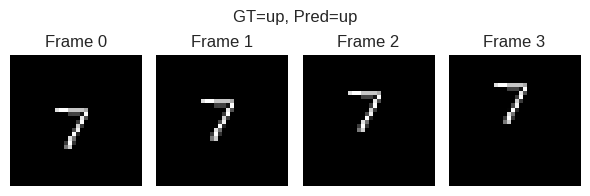

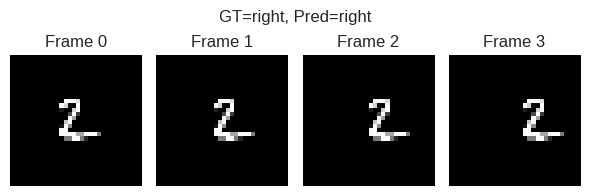

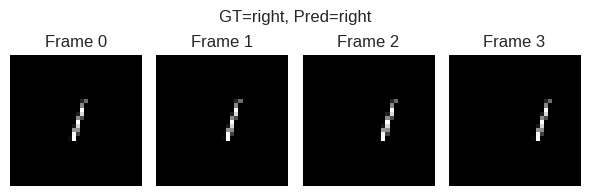

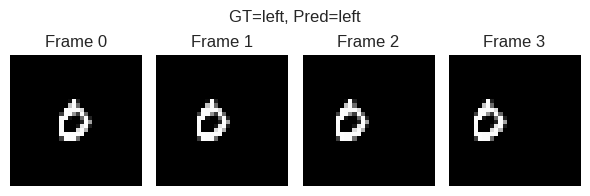

In [51]:
with torch.no_grad():
    for i in range(4):
        frames, label = test_dataset[i]
        frames = frames.to(device)
        pred = model(frames.unsqueeze(0))
        pred_label = test_dataset.LABELS[pred.argmax().item()]
    
        visualize_sequence(frames, n_cols=4, cmap="gray", suptitle=f"GT={test_dataset.LABELS[label]}, Pred={pred_label}")

# Assignment 4

#### **Task 1**
 - Implement a LSTM (LSTM() and/or LSTMCell()) from scratch
 - Implement a Convolutional LSTM (ConvLSTM() and/or ConvLSTMCell()) from scratch

#### **Task 2**
 1. Perform "Action Recognition" on the KTH-Actions dataset:
    - https://www.csc.kth.se/cvap/actions/
    - https://github.com/tejaskhot/KTH-Dataset
    - Already downloaded in `/home/nfs/inf6/data/datasets/kth_actions`
    - Use spatial dimensionality of frames of 64x64
    - Split videos into subsequences of e.g. 15 frames. Treat each of these subsequences as independent.
    - Feel free to use augmentations (temporal and/or spatial)
    

<br>

2. Implement a model with the following structure:
    - Convolutional encoder (probably more powerful than the one from above)
    - Recurrent module
    - Classifier (probably Conv + AvgPooling/Flattening + Linear)


<br>

3. Train, evaluate, and compare the model with the recurrent modules listed below.<br>
   Compare the models in terms of accuracy, training/inference time, and number of learnable parameters.<br>
   **Log the experiments on Tensorboard/WandB**. <br>
   RNNs to evaluate:
    - PyTorch LSTM model (using nn.LSTMCell)
    - PyTorch GRU model (using nn.GRUCell)
    - Your own LSTM
    - Your own ConvLSTM
    - **Note**: Different recurrent modules (e.g. LSTM vs ConvLSTM) might require slight changes in the encoder and classifier
    

#### **Extra Point**
  - Implement a 3D-CNN (e.g. 3D-ResNet or R(2+1)d-Net) for action classification on the KTH-Actions dataset
  - Compare it with the RNN-based models

#### **Due Date**: Monday 2nd December at 23:59
#### Submit it by mail using the subject: **CudaLab: Assignment4 + Group Name**
####  Send me the following: Jupyter Notebook after running, Jupyter export as html, any other .py files or images used.

### **Next Session: Wednesday 4th December**

# References
 - https://www.deeplearningbook.org/
 - https://towardsdatascience.com/all-you-want-to-know-about-deep-learning-8d68dcffc258
 - https://colah.github.io/posts/2015-08-Understanding-LSTMs/

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
    <b>Angel Villar-Corrales</b><br>
    <ul>
       <li> <b>Email</b>: villar@ais.uni-bonn.de
       <li> <b>Website</b>: angelvillarcorrales.com
    </ul>
</div>  